In [126]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html

In [127]:
# importeer nodige libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVR

In [128]:
# lees het bestand in
redwines = pd.read_csv("redwine.csv", delimiter=";", encoding='iso-8859-1')

In [129]:
# verwijder onnodige kolommen
redwines.drop(['country','variety'],axis=1, inplace=True)

In [130]:
# set column id als index
redwines.set_index('id', inplace=True)

In [131]:
# voeg jaartal toe als aparte kolom, en verwijder nan rijen voor jaren (2465 naar 2461)
redwines['year'] = redwines['title'].str.extract(r"([1][9][9]\d|[2][0][0,1,2]\d)")
redwines = redwines[redwines['year'].notnull()]

In [132]:
# drop rows with nan value in it
redwines.dropna(inplace=True)

## 4. Kan je op basis van score en prijs achterhalen in welke regio de wijn zijn oorsprong heeft.
Voor deze onderzoeksvraag is de data onderzocht per maand. Om deze vraag te beantwoorden, kijk ik eerst naar correlaties tussen de data van de maanden. Deze zijn gepresenteerd hieronder in een heatmap.

In [133]:
# Het omzetten van alle data gegroepeert op maand
redwines['count'] = 1
avg_per_province = redwines.groupby('province').sum() 
avg_per_province.loc[:, "points":"sulphates"] = avg_per_province.loc[:, "points":"sulphates"].div(avg_per_province['count'], axis=0)
avg_per_province['province'] = avg_per_province.index

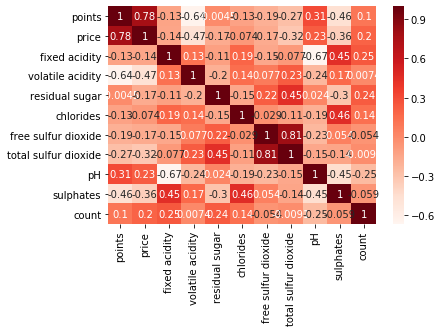

In [134]:
# Correlatieschema van alle gemiddeldes van alle maanden
correlation = avg_per_province.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)

tussen price en points zit een aardige correlatie. Wat betekent dat per regio de verhouding van punten gegeven door wijnproevers en de prijs aardig hoog ligt. Ook is de total sulfur dioxide ten opzichte van de sulfur vrije dioxide een aardige correlatie te vinden.

Ik wil nu verder met de correlatie tussen price en points.

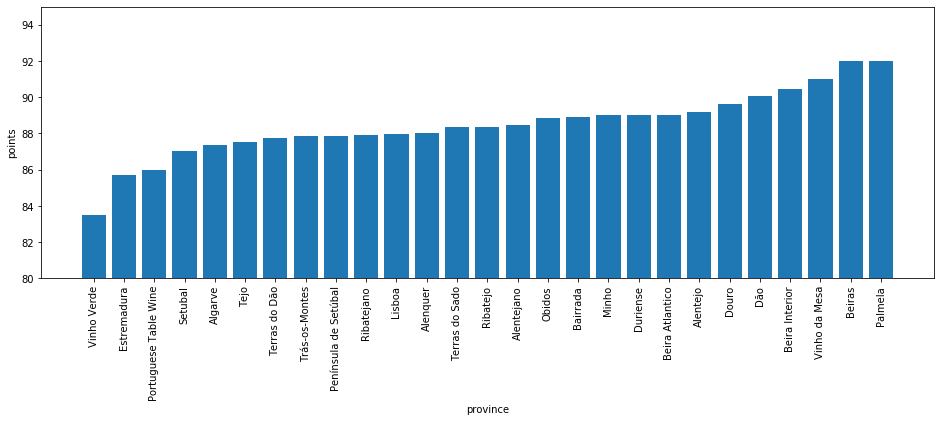

In [135]:
# Gemiddelde punten per regio
avg_points_sorted = avg_per_province.sort_values(by=['points'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(80, 95)
plt.bar(avg_points_sorted['province'], avg_points_sorted['points'])
plt.xlabel('province')
plt.ylabel('points')
plt.show()

het gemiddelde aantal punten per regio liggen niet ver van elkaar af. Op basis van alleen punten zullen we dus niet kunnen concluderen welke regio de wijn vandaan komt.

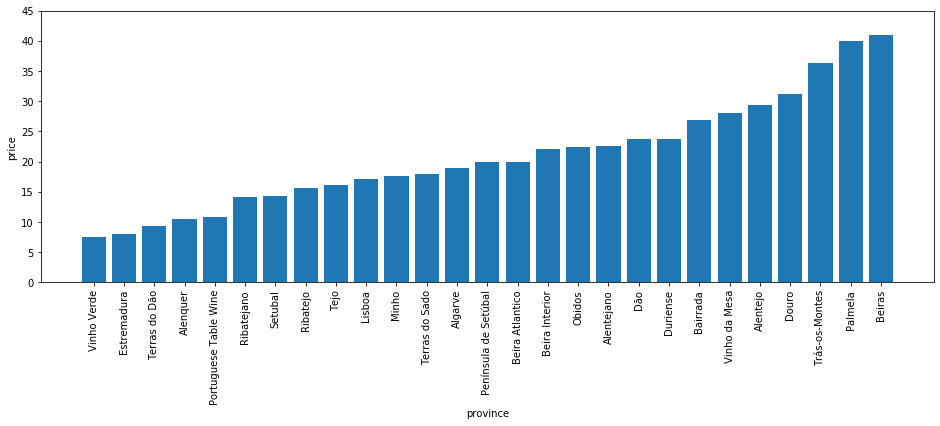

In [136]:
# Gemiddelde prijs per regio
avg_points_sorted = avg_per_province.sort_values(by=['price'])
plt.figure(figsize=(16,5))
plt.xticks(np.arange(27),(avg_points_sorted.index), rotation='vertical')
plt.ylim(0, 45)
plt.bar(avg_points_sorted['province'], avg_points_sorted['price'])
plt.xlabel('province')
plt.ylabel('price')
plt.show()

Uit de grafiek blijkt dat er best veel verschil zit tussen de gemiddelde prijs per provincie. Op basis van deze informatie ik een model bouwen welke a.d.h.v. prijs en score welke probeert te achterhalen waar de wijn vandaan komt.

Op het moment ben ik benieuwd of er een duidelijk verband is tussen de prijs en punten per maand. Hiervoor brengt ik de vorige twee grafieken in kaart in een grafiek gecategoriseerd op maand.

In [137]:
# Namen geven aan een variabel
avg_price = avg_per_province['price']
avg_points = avg_per_province['points']
index = avg_per_province.index

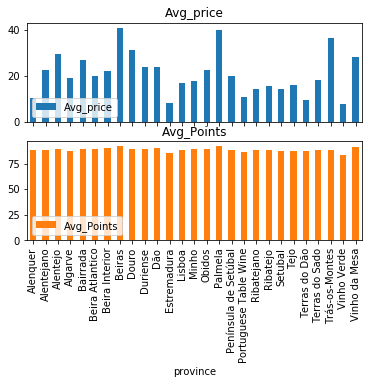

In [138]:
# Grafiek van gemiddelde prijs en punten per provincie
df = pd.DataFrame({'Avg_price': avg_price,
                   'Avg_Points': avg_points}, index = index)
axes = df.plot.bar(rot=90, subplots=True)
axes[0].legend(loc=3)
axes[1].legend(loc=3)

Ondanks de hogere correlatie (0,78) bij de heatmap tussen score en prijs gecategoriseerd per maand, zie ik niet heel veel bijzonders aan de grafiek hierboven. Een ding wat je wel kan waarnemen dat enkele provincies met gemiddeld hogere wijnprijzen een iets hogere gemiddelde score heeft. Zo ook met gemiddelde lage wijnprijzen en scores. Echter blijft dat een kleine ontdekking.

Toch wil ik een model in elkaar zetten wat een voorspelling doet op basis van de hoofdvraag.

In [139]:
# Omzetten van maand in een integer
month = {}
counter = 1
for item in avg_per_province.index:
    month[str(item)] = counter
    counter+=1
redwines['province'] = [month[str(item)] for item in redwines['province']]

In [148]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

32.69417475728156


Wat op viel was dat er 3 modellen aardig goed presteerden. De DecisionTreeClassifier functie aan top met een nauwkeurigheid van 33,3%. De functie logisticRegression had een nauwkeurigheid van 32,0% en DecisionTreeRegressor kwam met 14,5% nauwkeurigheid. Alle test zijn gedaan op basis van 10 testen en daarvan het gemiddelde.

Uit deze informatie blijkt dat er aan de hand van deze dataset geen goede voorspelling kan worden gedaan waar de wijn vandaan komt.

Hierna keek ik of er op basis van andere elementen een goede voorspelling kan worden gedaan. Ik heb nog maals enkele test gedaan met meer parameters.

In [147]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['total sulfur dioxide', 'price', 'points']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 100
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))
    

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

100.50726425014433


Met de functie DecisionTreeRegressor kan er tot 82,9 % nauwkeurigheid worden voorspelt welke regio er bij de wijn hoort op basis van totaal zwaveldioxide, prijs en punten.

Nu ben ik erg benieuwd of het model veel kan halen uit een stuk of 8 willekeurige colums.

In [146]:
# Variables een naam geven
dependent = redwines['province']
independent = redwines[['points', 'price', 'fixed acidity', 'volatile acidity','residual sugar', 'total sulfur dioxide', 'chlorides']]

# Een gemiddelde percentage als uitkomst nemen uit een x aantal testen
scores_in_percentage = []    
random_seed = 0
testen = 10
for i in range(testen):
    
    # Test en train set
    X_train, X_test, y_train, y_test = train_test_split(independent, dependent, random_state=random_seed, test_size=0.2)
    random_seed+=1
    
    # Training model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # Voeg de score toe aan lijst met gevonden scores
    scores_in_percentage.append(model.score(X_test, y_test))

# Rekent het gemiddelde uit van alle percentuele scores    
print(abs(((sum(scores_in_percentage)) / (len(scores_in_percentage))) * 100))

100.53600934794422


Door vorige trainingssessies van modellen is er te zien dat de functie DecisionTreeRegressor vaak het beste uit de test komt. Door het combineren van de punten points, price, fixed acidity, volatile acidity, residual sugar, total sulfur dioxide, chlorides, kan er met 92,4% nauwkeurigheid gegokt worden waar de wijn vandaan komt.

Mijn conclusie is dat er op basis van punten en scores geen voorspelling kan worden gemaakt waar de wijn vandaan komt, dat komt voornamelijk doordat points voor de wijn te dicht op elkaar ligt. Echter wanneer er meer parameters worden meegenomen, is er met 92,4% zekerheid te zeggen waar de wijn vandaan komt.